# Tugas Besar B
IF3270 Pembelajaran Mesin<br>
Backward Propagation - Mini Batch Gradient Descent

Developed by:
1. K01 13520010 - Ken Kalang Al Qalyubi
2. K01 13520036 - I Gede Arya Raditya Parameswara
3. K02 13520061 - Gibran Darmawan
4. K03 13520119 - Marchotridyo

## Main Program

### Library

In [410]:
import json, math
import networkx as nx
import matplotlib.pyplot as plt
from enum import Enum
import numpy as np
import random

### Enum

In [411]:
class LayerEnum(Enum):
    INPUT = "input"
    HIDDEN = "hidden"
    OUTPUT = "output"

class ActivationFuncEnum(Enum):
    SIGMOID = "sigmoid"
    LINEAR = "linear"
    RELU = "relu"
    SOFTMAX = "softmax"

### File Utility

In [412]:
class FileUtility:
    @staticmethod
    def import_json(file_name):
        with open(file_name) as json_file:
            return json.load(json_file)

    @staticmethod
    def export_json(file_name, data):
        with open(file_name, 'w') as outfile:
            json.dump(data, outfile)

### Activation

In [413]:
class Activation:
    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    @staticmethod
    def linear(x):
        return x
    
    @staticmethod
    def relu(x):
        return np.maximum(0, x)
    
    @staticmethod
    def softmax(x):
        return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)

    @staticmethod
    def derivative_sigmoid(x):
        return Activation.sigmoid(x) * (1 - Activation.sigmoid(x))
    
    @staticmethod
    def derivative_linear( x):
        return 1
    
    @staticmethod
    def derivative_relu( x):
        return 1 if x >= 0 else 0
    
    @staticmethod
    def derivative_softmax( x):
        return -(1 - x)
    

### Layer

In [414]:
class Layer:
    # Layer adalah kelas yang menyimpan sejumlah neutron berikut fungsi aktivasinya
    def __init__(self, neurons: list, type: str, activation_func: str):
        self.__neurons = neurons
        self.__type = type
        self.__activation_func = activation_func

    def display(self):
        print("Layer Type: " + self.__type)
        print("Neurons: ")
        for neuron in self.__neurons:
            neuron.display()

    def add_neuron(self, neuron):
        self.__neurons.append(neuron)

    def get_neurons(self):
        return self.__neurons
    
    def get_type(self):
        return self.__type
    
    def get_activation_func(self):
        return self.__activation_func

### Error Counter

In [415]:
class ErrorCounter:
    @staticmethod
    def sum_squared_error(y_true: np.ndarray, y_pred: np.ndarray) -> float:
        return np.sum((y_true - y_pred) ** 2)

### Neuron

In [416]:
class Neuron:
    def __init__(
        self, 
        layer: Layer,
        weight: list,
    ):
        self.__layer: Layer = layer
        self.__weight: list = weight
        # __temp_weight digunakan untuk menyimpan cummulative perubahan __weight (saat mini-batch)
        self.__temp_weight: list = self.__weight[:]
        self.__net: float = 0.0
        self.__value: float = 0.0
        self.__error_term = 0.0

    def activate(self):
        if self.__layer.get_activation_func() == ActivationFuncEnum.SIGMOID.value:
            self.__value = 1 / (1 + math.exp(-self.__net))
        elif self.__layer.get_activation_func() == ActivationFuncEnum.LINEAR.value:
            self.__value = self.__net
        elif self.__layer.get_activation_func() == ActivationFuncEnum.RELU.value:
            self.__value = max(0, self.__net)
        elif self.__layer.get_activation_func() == ActivationFuncEnum.SOFTMAX.value:
            try:
                layer_neurons: list = self.__layer.get_neurons()
                exp_sum: float = 0.0

                for neuron in layer_neurons:
                    exp_sum += math.exp(neuron.get_net())

                self.__value = math.exp(self.__net) / exp_sum
            except Exception as e:
                self.__value = 0.0

    def set_value(self, value):
        self.__value = value

    def set_net(self, net):
        self.__net = net

    def set_weight(self, index, weight):
        self.__weight[index] = weight

    def set_temp_weight(self, index, weight):
        self.__temp_weight[index] = weight

    def set_error_term(self, error_term):
        self.__error_term = error_term

    def get_value(self):
        return self.__value

    def get_net(self):
        return self.__net

    def get_weight(self, index):
        return self.__weight[index] 
    
    def get_weights(self):
        return self.__weight
    
    def get_temp_weight(self, index):
        return self.__temp_weight[index] 
    
    def get_temp_weights(self):
        return self.__temp_weight
    
    
    def get_error_term(self):
        return self.__error_term

### ANN Graph

In [417]:
class ANNGraph:
    def __init__(self, file_config_path: str):
        # Set file
        self.file_path = file_config_path
        self.config = None

        # Inisialisasi layers
        self.layers: list[Layer] = []

        # Buat graf ANN --> pengisian self.layers
        self.__build_ann_graph()

    def __build_ann_graph(self):
        # Baca .json, masukkan ke config
        self.config = FileUtility.import_json(self.file_path)

        # Baca input pertama: input layer
        input_layer = Layer([], LayerEnum.INPUT.value, "")
        ## Masukkan neuron. Untuk input layer, weightnya dikosongkan karena tidak digunakan dalam kalkulasi
        input_size = self.config["case"]["model"]["input_size"]
        for i in range(input_size):
            neuron = self.__generate_neuron_data(input_layer, {"weights": []})
            input_layer.add_neuron(neuron)
        ## Input layer masuk ke dalam self.layers
        self.layers.append(input_layer)

        # Baca layer-layer selanjutnya
        layers = self.config["case"]["model"]["layers"]
        ## Proses setiap layer
        for i, layer in enumerate(layers):
            # By default, dia HIDDEN kecuali merupakan layer terakhir
            layer_type = LayerEnum.HIDDEN.value
            if i == len(layers) - 1:
                layer_type = LayerEnum.OUTPUT.value

            # Inisialisasi instance layer
            curr_layer = Layer([], layer_type, layer["activation_function"])

            # Memasukkan neuron ke curr_layer
            layer_weights = self.config["case"]["initial_weights"][i]
            ## Proses untuk setiap layer_weight
            for j in range(layer["number_of_neurons"]):
                neuron_weights = []
                # Weight di layout secara vertikal
                for k in range(len(layer_weights)):
                    neuron_weights.append(layer_weights[k][j])
                neuron = self.__generate_neuron_data(curr_layer, {"weights": neuron_weights})
                curr_layer.add_neuron(neuron)

            # Masukkan curr_layer ke self.layers
            self.layers.append(curr_layer)
        
        return

    def __generate_neuron_data(self, layer: Layer, neuron_data):
        # Fungsi ini membuat suatu instance Neuron berdasarkan data yang diberikan pada layer yang diberikan
        weights: list = []

        if (layer.get_type() == LayerEnum.HIDDEN.value or layer.get_type() == LayerEnum.OUTPUT.value):
            weights = neuron_data["weights"]

        return Neuron(layer, weights)
    
    def __forward_propagation(self, input_data: list[float]):
        # Melakukan proses feed forward berdasarkan input_data
        # print(f"forward propagation: {input_data}")

        # Masukkan dulu data input ke neuron di layer input
        for i in range(len(input_data)):
            # neuron adalah neuron ke-i di input layer (layers[0])
            neuron: Neuron = self.layers[0].get_neurons()[i]
            neuron.set_value(input_data[i])

        # Lakukan proses feed forward: menghitung nilai output di setiap unit (dalam kasus ini menghitung setiap value di setiap neuron)
        for i, layer in enumerate(self.layers):
            # Jika layer merupakan input layer, tidak perlu diproses
            if layer.get_type() == LayerEnum.INPUT.value:
                continue

            previous_layer = self.layers[i - 1]

            # Hitung dulu masing-masing netnya, baru dihitung valuenya
            for neuron in layer.get_neurons():
                # print(neuron.get_weights())
                # Hitung net
                total = neuron.get_weight(0)

                previous_neurons: list[Neuron] = previous_layer.get_neurons()
                for i, prev_neuron in enumerate(previous_neurons):
                    # i + 1 karena .get_weight(0) adalah bias
                    total += prev_neuron.get_value() * neuron.get_weight(i + 1)

                neuron.set_net(total)
                # print(f">> {total}")
    
            for neuron in layer.get_neurons():
                neuron.activate()

        return
    
    def __backward_propagation(self, target_data: list[float], update = False):
        # Melakukan proses backward propagation berdasarkan target_data

        # Hitung nilai error term untuk setiap neuron di layer output
        output_layer: Layer = self.layers[len(self.layers) - 1]
        output_neurons: list[Neuron] = output_layer.get_neurons()
        ## Assign error_term dari setiap output_neuron
        for j, output_neuron in enumerate(output_neurons):
            # Kalkulasi chain rule dengan tujuan mencari ded_dnetj
            ded_dnetj = 0.0
            
            ## Turunan terhadap oj
            oj = output_neuron.get_value()
            ded_doj = -1 * (target_data[j] - oj)
            ## Turunan terhadap netj
            doj_dnetj = 0.0
            activation_func = output_layer.get_activation_func()
            if activation_func == ActivationFuncEnum.LINEAR.value:
                doj_dnetj = 1.0
            elif activation_func == ActivationFuncEnum.RELU.value:
                net = output_neuron.get_net()
                if net < 0.0:
                    doj_dnetj = 0.0
                else:
                    doj_dnetj = 1.0
            elif activation_func == ActivationFuncEnum.SIGMOID.value:
                doj_dnetj = oj * (1 - oj)
            elif activation_func == ActivationFuncEnum.SOFTMAX.value:
                # Cek apakah j targetClass
                if target_data[j] == 1.0:
                    ded_dnetj = -1 * (1 - oj)
                else:
                    ded_dnetj = oj

            if activation_func != ActivationFuncEnum.SOFTMAX.value:
                ded_dnetj = ded_doj * doj_dnetj

            ## Set error term = -1 * ded_doj * doj_dnetj atau -1 * ded_dnetj
            output_neuron.set_error_term(-1 * ded_dnetj)
            pass

        # Hitung nilai error term untuk setiap neuron di layer hidden
        for i in range(len(self.layers) - 2, -1, -1):
            curr_layer: Layer = self.layers[i]

            # Jika ini layer input, pemrosesan selesai
            if curr_layer.get_type() == LayerEnum.INPUT.value:
                break

            curr_neurons: list[Neuron] = curr_layer.get_neurons()

            ## Dalam menghitung de_dneth di tahap selanjutnya, perlu data next layer
            next_layer: Layer = self.layers[i + 1]
            next_neurons: list[Neuron] = next_layer.get_neurons()
        
            for h, hidden_neuron in enumerate(curr_neurons):
                # Kalkulasi chain rule
                oh = hidden_neuron.get_value()

                # Turunan terhadap net, akan dihitung untuk set error term
                ded_dneth = 0.0

                ## Menghitung doh_dneth, dipakai saat menghitung ded_dneth
                doh_dneth = 0.0
                activation_func = curr_layer.get_activation_func()
                if activation_func == ActivationFuncEnum.LINEAR.value:
                    doh_dneth = 1.0
                elif activation_func == ActivationFuncEnum.RELU.value:
                    net = hidden_neuron.get_net()
                    if net < 0.0:
                        doh_dneth = 0.0
                    else:
                        doh_dneth = 1.0
                elif activation_func == ActivationFuncEnum.SIGMOID.value:
                    doh_dneth = oh * (1 - oh)
                elif activation_func == ActivationFuncEnum.SOFTMAX.value:
                    # Tidak mungkin target class
                    doh_dneth = oh

                for next_neuron in next_neurons:
                    # Hitung nilai dari ded_dnetk * dnetk_doh  * doh_dneth
                    ded_dnetk = -1 * next_neuron.get_error_term()
                    dnetk_doh = next_neuron.get_weight(h + 1)
                    ded_dneth += ded_dnetk * dnetk_doh * doh_dneth

                # print(f'hidden: ded_neth = {ded_dneth}')

                # Set error term = -1 * ded_dneth
                hidden_neuron.set_error_term(-1 * ded_dneth)
        
        # Update bobot!
        learning_rate = self.config["case"]["learning_parameters"]["learning_rate"]
        for i in range(len(self.layers) - 1, -1, -1):
            curr_layer: Layer = self.layers[i]

            # Jika ini layer input, pemrosesan selesai
            if curr_layer.get_type() == LayerEnum.INPUT.value:
                break

            curr_neurons: list[Neuron] = curr_layer.get_neurons()

            # Data previous layer dibutuhkan untuk mendapatkan nilai xji
            prev_layer: Layer = self.layers[i - 1]
            prev_neurons: list[Neuron] = prev_layer.get_neurons()

            for j, neuron in enumerate(curr_neurons):
                weights: list[float] = neuron.get_weights()

                # print(f"Update neuron ke-{j}")

                for k in range(len(weights)):
                    # Default case, untuk bias, xji = 1
                    xji = 1
                    
                    if k != 0:
                        # Bukan bias
                        xji = prev_neurons[k - 1].get_value()

                    delta = learning_rate * neuron.get_error_term() * xji
                    # print(f"delta untuk weight ke-{k}:", delta)

                    # print(f"{learning_rate} >< {neuron.get_error_term()} >< {xji}")
                    # print(f"Melakukan update weight dari {weight} menjadi {weight + delta}")

                    neuron.set_temp_weight(k, neuron.get_temp_weight(k) + delta)

                    if update:
                        # print("Update bosku!")
                        neuron.set_weight(k, neuron.get_temp_weight(k))
        
        return
    
    def __train(self):
        # Melakukan pelatihan sampai terminasi tercapai
        iter = 1

        # Ambil nilai-nilai dari config
        max_iteration = self.config["case"]["learning_parameters"]["max_iteration"]
        batch_size = self.config["case"]["learning_parameters"]["batch_size"]
        error_threshold = self.config["case"]["learning_parameters"]["error_threshold"]
        inputs = len(self.config["case"]["input"])

        # Mulai pemrosesan dari pasangan (x, t) pertama
        index = 0
        processed = 0
        error = 0.0
        self.sum_delta_weight = 0

        while True:
            processed += 1

            input_vector = self.config["case"]["input"][index]
            target_vector = self.config["case"]["target"][index]
            self.__forward_propagation(input_vector)
            # Jika processed % batch_size == 0, artinya mini-batch selesai diproses, lakukan update bobot.
            # print(f"processed: {processed} || batch_size: {batch_size}")
            self.__backward_propagation(target_vector, processed % batch_size == 0)

            index += 1

            # Hitung error
            output_layer: Layer = self.layers[len(self.layers) - 1]
            output_neurons: list[Neuron] = output_layer.get_neurons()
            if output_layer.get_activation_func() != ActivationFuncEnum.SOFTMAX.value:
                # Jika bukan softmax,
                for i, neuron in enumerate(output_neurons):
                    error += ((target_vector[i] - neuron.get_value()) ** 2) / 2
            else:
                # Jika softmax,
                for i, neuron in enumerate(output_neurons):
                    if target_vector[i] == 1.0:
                        error += -1 * np.log(neuron.get_value())

            if index >= inputs:
                print(f"Epoch: {iter} || Error: {error}")
                
                # Kondisi akhir #1: Error < error_threshold
                if error < error_threshold:
                    print("Error < error threshold!")
                    break

                # Kondisi akhir #2: Mencapai maksimum iterasi
                if iter >= max_iteration:
                    print("Max iteration reached!")
                    break

                # Reset error, mulai epoch baru
                iter += 1
                error = 0.0
                index = 0
                processed = 0

    def show_weights(self):
        # Cetak weight dengan format yang sama dengan final_weights
        weights = []
        for layer in self.layers:
            # Tidak perlu cetak weight dari input layer
            if layer.get_type() == LayerEnum.INPUT.value:
                continue

            layer_weight = []
            for i in range(len(layer.get_neurons()[0].get_weights())):
                level_weight = []
                for neuron in layer.get_neurons():
                    level_weight.append(neuron.get_weight(i))
                layer_weight.append(np.array(level_weight, dtype=object))
            weights.append(np.array(layer_weight, dtype=object))
        
        print(np.array(weights, dtype=object))
    
    def draw_ann_graph(self, figsize=(6, 6)):
        # Terminologies:
        # Xi = neuron ke-i di input layer
        # Hij = neuron ke-j di hidden layer ke-i
        # Oi = neuron ke-i di output layer

        G = nx.DiGraph()

        # Proses setiap layer
        for i, layer in enumerate(self.layers):
            if i == 0:
                continue

            prev_layer = self.layers[i - 1]
            prev_prefix = ""
            prefix = ""

            if prev_layer.get_type() == LayerEnum.INPUT.value:
                prev_prefix = "X"
            elif prev_layer.get_type() == LayerEnum.HIDDEN.value:
                prev_prefix = f"H{i - 1}"
            else:
                prev_prefix = "O"
            
            if layer.get_type() == LayerEnum.INPUT.value:
                prefix = "X"
            elif layer.get_type() == LayerEnum.HIDDEN.value:
                prefix = f"H{i}"
            else:
                prefix = "O"

            # Tambahkan edge dari setiap neuron di prev_layer ke layer
            for j, _ in enumerate(prev_layer.get_neurons()):
                for k, neuron in enumerate(layer.get_neurons()):
                    if j == 0:
                        print(f"Bobot bias untuk {prefix}{k + 1} = {neuron.get_weight(0)}")
                    G.add_edge(f"{prev_prefix}{j + 1}", f"{prefix}{k + 1}", weight=neuron.get_weight(j + 1))
            
        # Set posisi node graph
        pos = {}
        curr_x = 0
        for i, layer in enumerate(self.layers):
            curr_y = 0

            prefix = ""
            if layer.get_type() == LayerEnum.INPUT.value:
                prefix = "X"
            elif layer.get_type() == LayerEnum.HIDDEN.value:
                prefix = f"H{i}"
            else:
                prefix = "O"
            
            for j, _ in enumerate(layer.get_neurons()):
                pos[f"{prefix}{j + 1}"] = (curr_x, curr_y)
                curr_y += 1

            curr_x += 1

        options = {
            "font_size": 12,
            "node_size": 2000,
            "node_color": "white",
            "edgecolors": "black",
            "linewidths": 5,
            "width": 5,
        }

        _, ax = plt.subplots(figsize=figsize)
        nx.draw_networkx(G, pos, **options, ax=ax)
        edge_labels = nx.get_edge_attributes(G, "weight")
        nx.draw_networkx_edge_labels(G, pos, edge_labels, label_pos=0.6)

        ax = plt.gca()
        ax.margins(0.2)
        plt.axis("off")
        plt.show()

    def solve(self):
        self.__train()

## Testing

Bobot bias untuk O1 = 0.1
Bobot bias untuk O2 = 0.3
Bobot bias untuk O3 = 0.2


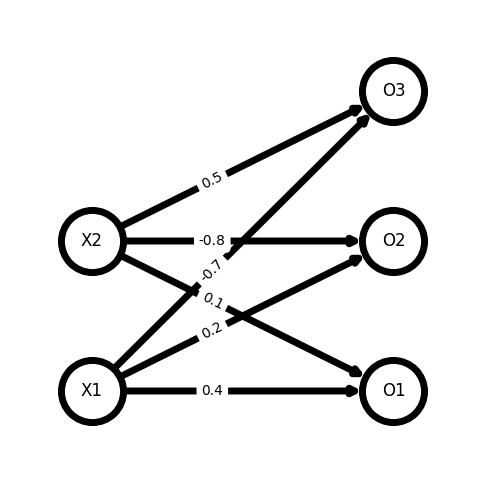

Epoch: 1 || Error: 0.665
Max iteration reached!
[[[0.10120000000000001 0.3006 0.1991]
  [0.40240000000000004 0.201 -0.7018999999999999]
  [0.10180000000000002 -0.799 0.4987]]]


In [418]:
graph = ANNGraph("config/linear_small_lr.json")
graph.draw_ann_graph()
graph.solve()
graph.show_weights()

Bobot bias untuk O1 = 0.1
Bobot bias untuk O2 = 0.3
Bobot bias untuk O3 = 0.2


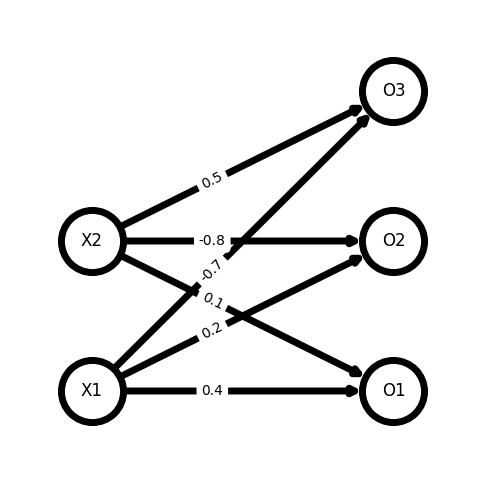

Epoch: 1 || Error: 0.665
Epoch: 2 || Error: 0.1818500000000002
Max iteration reached!
[[[0.166 0.33799999999999997 0.15300000000000008]
  [0.502 0.22599999999999995 -0.7889999999999999]
  [0.21400000000000008 -0.718 0.42700000000000005]]]


In [419]:
graph = ANNGraph("config/linear_two_iteration.json")
graph.draw_ann_graph()
graph.solve()
graph.show_weights()

Bobot bias untuk O1 = 0.1
Bobot bias untuk O2 = 0.3
Bobot bias untuk O3 = 0.2


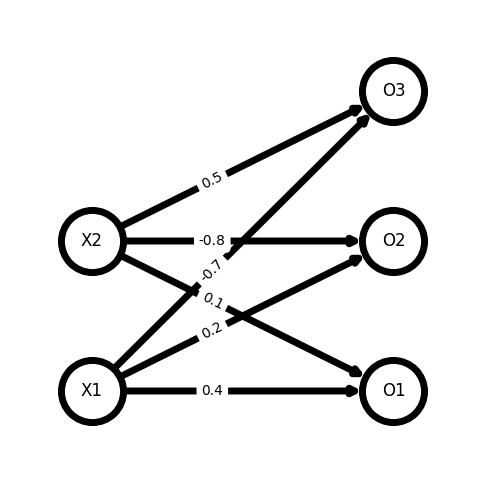

Epoch: 1 || Error: 0.665
Max iteration reached!
[[[0.21999999999999997 0.36 0.10999999999999999]
  [0.64 0.30000000000000004 -0.8900000000000001]
  [0.28 -0.7 0.36999999999999994]]]


In [420]:
graph = ANNGraph("config/linear.json")
graph.draw_ann_graph()
graph.solve()
graph.show_weights()

Bobot bias untuk H11 = 0.1
Bobot bias untuk H12 = 0.2
Bobot bias untuk O1 = 0.1
Bobot bias untuk O2 = 0.2


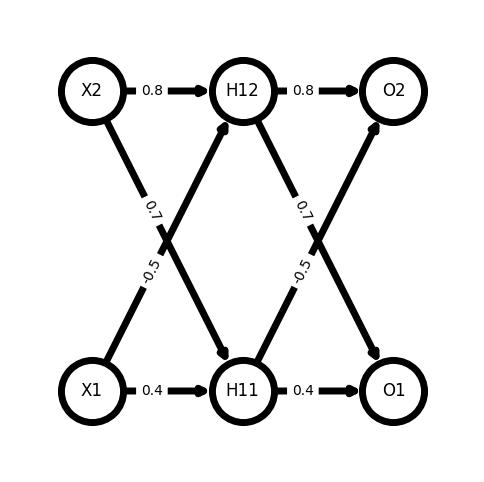

Epoch: 1 || Error: 0.8185625000000001
Max iteration reached!
[[[0.07115 0.1403]
  [0.42885 -0.44029999999999997]
  [0.6855749999999999 0.77015]]

 [[0.02099999999999999 0.1945]
  [0.39605 -0.500275]
  [0.6131 0.79395]]]


In [421]:
graph = ANNGraph("config/mlp.json")
graph.draw_ann_graph()
graph.solve()
graph.show_weights()

Bobot bias untuk O1 = 0.1
Bobot bias untuk O2 = 0.2
Bobot bias untuk O3 = 0.3


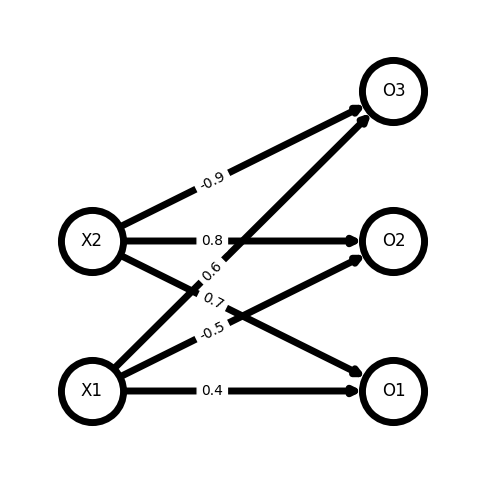

Epoch: 1 || Error: 0.14625000000000002
Max iteration reached!
[[[0.10500000000000001 0.19 0.25]
  [0.395 -0.49 0.575]
  [0.7025 0.795 -0.85]]]


In [422]:
graph = ANNGraph("config/relu.json")
graph.draw_ann_graph()
graph.solve()
graph.show_weights()

Bobot bias untuk O1 = 0.15
Bobot bias untuk O2 = 0.25


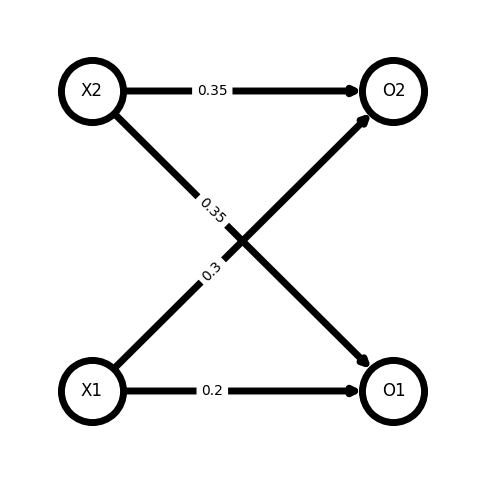

Epoch: 1 || Error: 1.0855286440512353
Epoch: 2 || Error: 1.0794460874330905
Epoch: 3 || Error: 1.0734081036395293
Epoch: 4 || Error: 1.0674201849030998
Epoch: 5 || Error: 1.0614876128061133
Epoch: 6 || Error: 1.0556154196513714
Epoch: 7 || Error: 1.0498083527755973
Epoch: 8 || Error: 1.0440708424411773
Epoch: 9 || Error: 1.0384069738568922
Epoch: 10 || Error: 1.0328204637754925
Epoch: 11 || Error: 1.0273146419995067
Epoch: 12 || Error: 1.0218924380015322
Epoch: 13 || Error: 1.016556372736673
Epoch: 14 || Error: 1.0113085555981398
Epoch: 15 || Error: 1.0061506863472651
Epoch: 16 || Error: 1.00108406174076
Epoch: 17 || Error: 0.9961095864845153
Epoch: 18 || Error: 0.9912277880672765
Epoch: 19 || Error: 0.9864388349706118
Epoch: 20 || Error: 0.9817425577143316
Epoch: 21 || Error: 0.9771384721783867
Epoch: 22 || Error: 0.9726258046420584
Epoch: 23 || Error: 0.9682035179969657
Epoch: 24 || Error: 0.9638703386196574
Epoch: 25 || Error: 0.9596247834296524
Epoch: 26 || Error: 0.955465186706921

In [423]:
graph = ANNGraph("config/sigmoid_mini_batch_GD.json")
graph.draw_ann_graph()
graph.solve()
graph.show_weights()

Bobot bias untuk O1 = 0.15
Bobot bias untuk O2 = 0.25


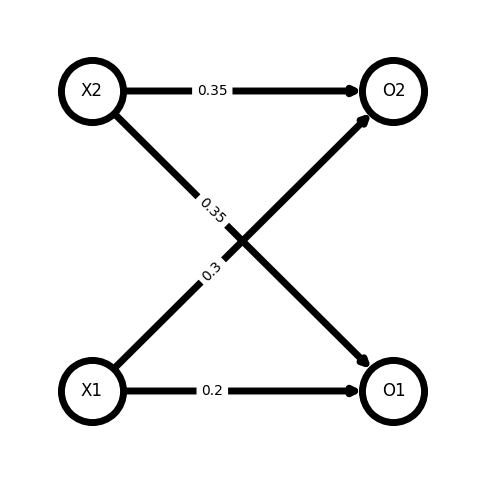

Epoch: 1 || Error: 1.0937222455706277
Epoch: 2 || Error: 1.0877221206717664
Epoch: 3 || Error: 1.0817601430224055
Epoch: 4 || Error: 1.0758416633115422
Epoch: 5 || Error: 1.069971862016267
Epoch: 6 || Error: 1.064155711973327
Epoch: 7 || Error: 1.0583979432159099
Epoch: 8 || Error: 1.0527030106934354
Epoch: 9 || Error: 1.0470750654285603
Epoch: 10 || Error: 1.0415179295841595
Epoch: 11 || Error: 1.036035075816941
Epoch: 12 || Error: 1.0306296111875124
Epoch: 13 || Error: 1.0253042657835414
Epoch: 14 || Error: 1.020061386097802
Epoch: 15 || Error: 1.0149029330909352
Epoch: 16 || Error: 1.009830484763897
Epoch: 17 || Error: 1.0048452429710322
Epoch: 18 || Error: 0.9999480441243787
Epoch: 19 || Error: 0.9951393733752872
Epoch: 20 || Error: 0.9904193818118708
Epoch: 21 || Error: 0.9857879061804741
Epoch: 22 || Error: 0.9812444906257446
Epoch: 23 || Error: 0.9767884099457789
Epoch: 24 || Error: 0.9724186938744414
Epoch: 25 || Error: 0.9681341519301936
Epoch: 26 || Error: 0.963933398407258
E

In [424]:
graph = ANNGraph("config/sigmoid_stochastic_GD.json")
graph.draw_ann_graph()
graph.solve()
graph.show_weights()

Bobot bias untuk O1 = 0.4
Bobot bias untuk O2 = 0.7


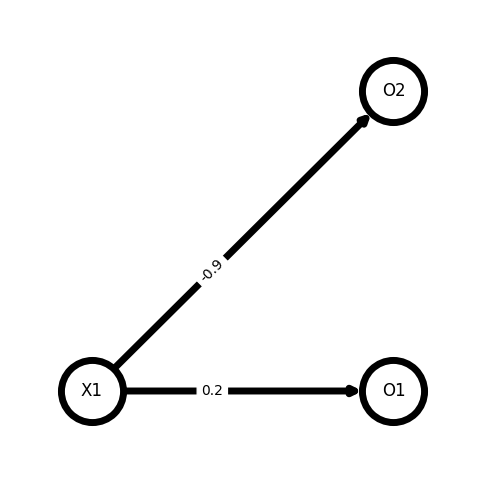

Epoch: 1 || Error: 0.22041740991845085
Error < error threshold!
[[[0.3802183888558582 0.7197816111441417]
  [0.21978161114414185 -0.9197816111441418]]]


In [425]:
graph = ANNGraph("config/softmax_error_only.json")
graph.draw_ann_graph()
graph.solve()
graph.show_weights()

Bobot bias untuk O1 = 0.1
Bobot bias untuk O2 = 0.2


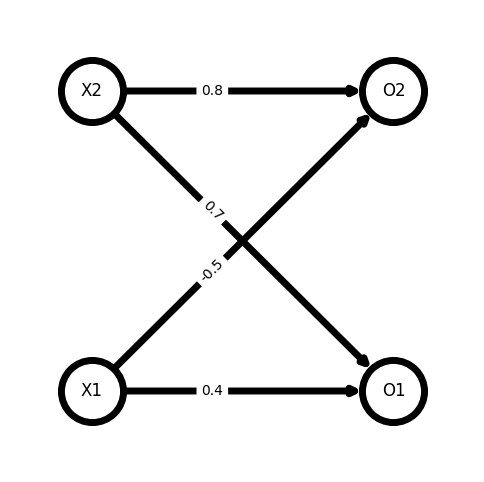

Epoch: 1 || Error: 2.2933074256150983
Max iteration reached!
[[[0.11301356652329322 0.18698643347670682]
  [0.29539054838432355 -0.3953905483843235]
  [0.7981026683540299 0.7018973316459701]]]


In [426]:
graph = ANNGraph("config/softmax.json")
graph.draw_ann_graph()
graph.solve()
graph.show_weights()

Bobot bias untuk O1 = 0.5
Bobot bias untuk O2 = 0.5


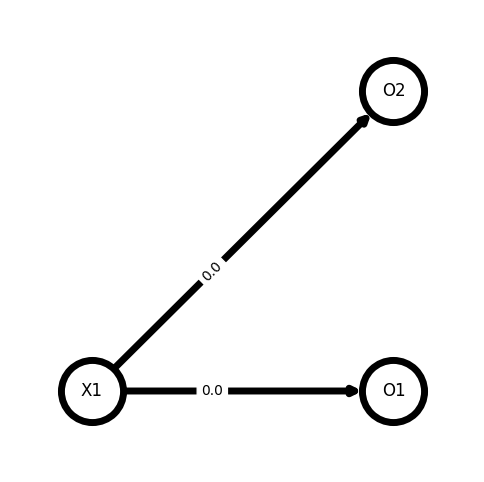

Epoch: 1 || Error: 0.25
Epoch: 2 || Error: 0.245025
Error < error threshold!
[[[0.49005 0.50995]
  [0.0 0.0]]]


In [427]:
graph = ANNGraph("config/sse_only.json")
graph.draw_ann_graph()
graph.solve()
graph.show_weights()

# Training menggunakan data Iris

## Membuat model untuk dilatih

In [428]:
from sklearn import datasets

def generate_iris_to_train():
    iris = datasets.load_iris()
    # print(iris)

    # Definisikan model untuk nanti disave
    model = {
        "case": {}
    }

    # Definisikan modelnya
    ## Iris punya 4 input --> input_size = 4
    ## Buat dua buah layer: satu hidden layer, neuron = 8, sigmoid  dan satu output layer, neuron = 3 (ada 3 kelas), softmax
    model["case"]["model"] = {
        "input_size": 4,
        "layers": [
            {
                "number_of_neurons": 8,
                "activation_function": "sigmoid"
            },
            {
                "number_of_neurons": 3,
                "activation_function": "softmax"
            }
        ]
    }

    # Ambil inputnya
    model["case"]["input"] = iris.data.tolist()

    # Definisikan weightsnya
    relu_weights = []
    ## Setiap neuron di sigmoid akan memiliki 3 weight: 1 bias, 4 dari input. Ada 8 neuron
    for i in range(5):
        random_weight = [random.uniform(-0.05, 0.05), random.uniform(-0.05, 0.05), random.uniform(-0.05, 0.05), random.uniform(-0.05, 0.05),
                        random.uniform(-0.05, 0.05), random.uniform(-0.05, 0.05), random.uniform(-0.05, 0.05), random.uniform(-0.05, 0.05)]
        relu_weights.append(random_weight)
    ## Setiap neuron di softmax akan memiliki 9 weight: 1 bias, 8 dari ReLU. Ada 3 neuron
    softmax_weights = []
    for i in range(9):
        random_weight = [random.uniform(-0.05, 0.05), random.uniform(-0.05, 0.05), random.uniform(-0.05, 0.05)]
        softmax_weights.append(random_weight)
    ## Masukkan ke dalam model
    model["case"]["initial_weights"] = []
    model["case"]["initial_weights"].append(relu_weights)
    model["case"]["initial_weights"].append(softmax_weights)


    # Ambil targetnya
    # Dibuat dalam one hot encoding: [1, 0, 0] jika setosa; [0, 1, 0] jika versicolor; [0, 0, 1] jika virginica
    model["case"]["target"] = []
    for target in iris.target:
        if target == 0:
            model["case"]["target"].append([1, 0, 0])
        elif target == 1:
            model["case"]["target"].append([0, 1, 0])
        else:
            model["case"]["target"].append([0, 0, 1])

    # Atur learning parametersnya
    model["case"]["learning_parameters"] = {
        "learning_rate": 5e-3,
        "batch_size": 2,
        "max_iteration": 10000,
        "error_threshold": 0.1
    }
            
    # Save model di file
    jsonString = json.dumps(model)
    jsonFile = open("to_train/iris.json", "w")
    jsonFile.write(jsonString)
    jsonFile.close()

# generate_iris_to_train()

## Melakukan pelatihan pada model dan menunjukkan hasil pelatihannya

Before training:
Bobot bias untuk H11 = -0.00502808341889234
Bobot bias untuk H12 = -0.025075462746789123
Bobot bias untuk H13 = -0.03866846129468098
Bobot bias untuk H14 = -0.024720831106776333
Bobot bias untuk H15 = 0.01592012307159417
Bobot bias untuk H16 = 0.020194718934448103
Bobot bias untuk H17 = -0.03384732764253165
Bobot bias untuk H18 = 0.030124461976936925
Bobot bias untuk O1 = 0.034042402533404
Bobot bias untuk O2 = 0.016471999274220314
Bobot bias untuk O3 = 0.04346622860197312


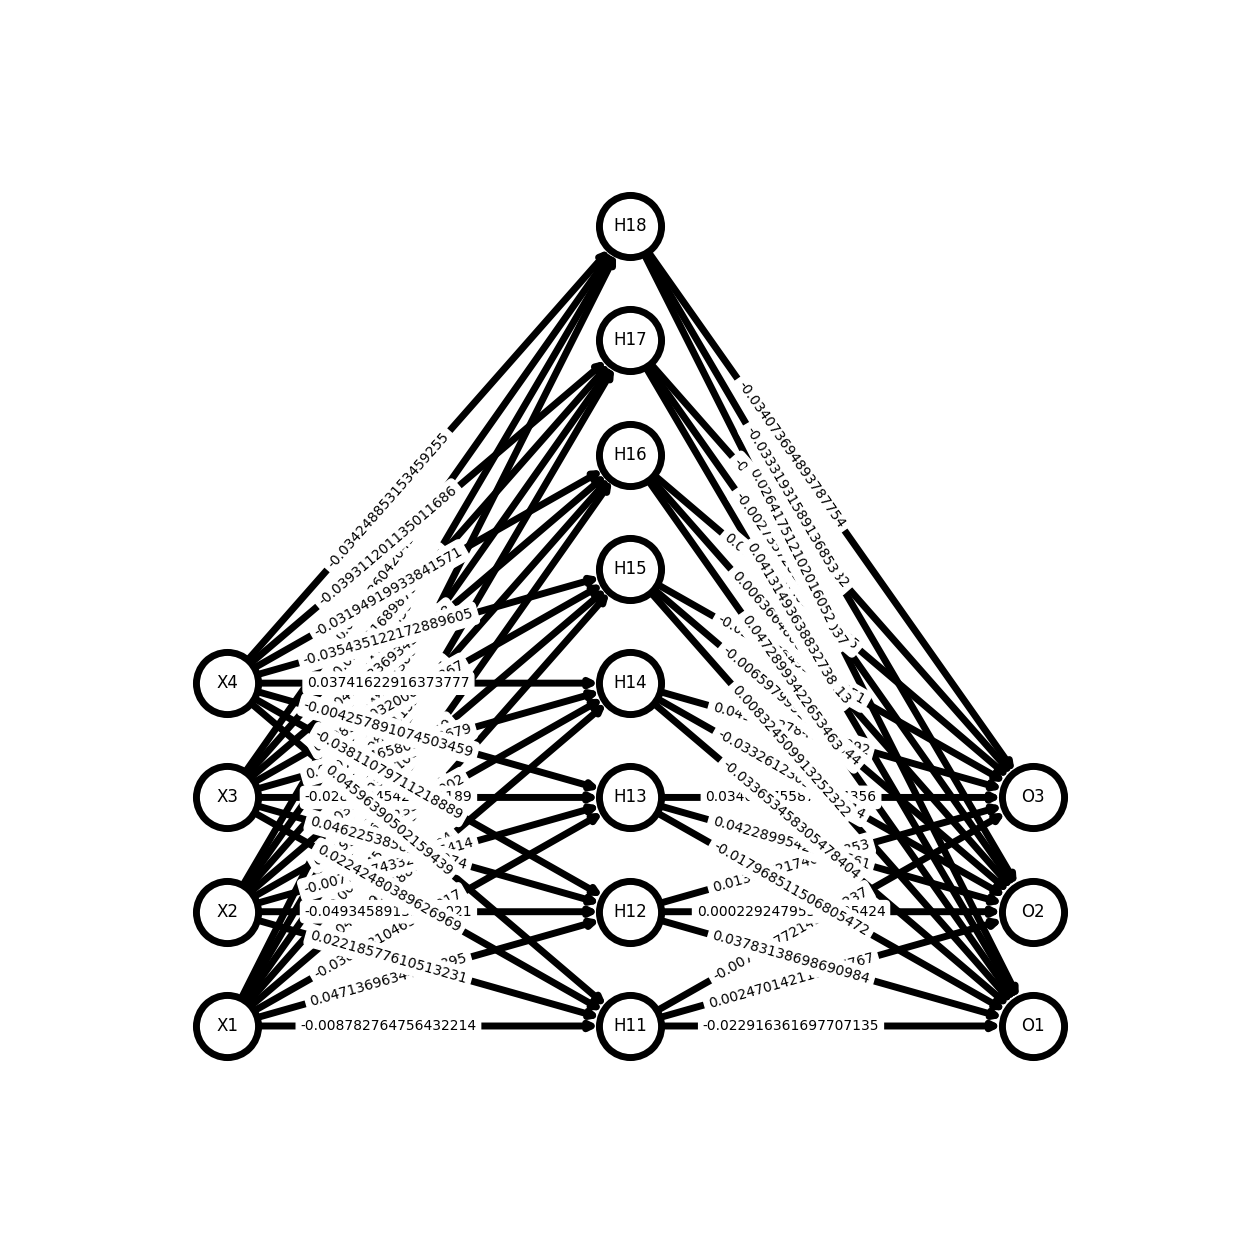

Epoch: 1 || Error: 161.81703041670124
Epoch: 2 || Error: 162.98236798056755
Epoch: 3 || Error: 163.65464225359102
Epoch: 4 || Error: 163.85695740733007
Epoch: 5 || Error: 163.75207453803972
Epoch: 6 || Error: 163.42702219015806
Epoch: 7 || Error: 162.90873490842975
Epoch: 8 || Error: 162.19109682478233
Epoch: 9 || Error: 161.25203758727156
Epoch: 10 || Error: 160.06083020473116
Epoch: 11 || Error: 158.57784304579903
Epoch: 12 || Error: 156.75200774222694
Epoch: 13 || Error: 154.5232432015037
Epoch: 14 || Error: 151.83364615813736
Epoch: 15 || Error: 148.643866086519
Epoch: 16 || Error: 144.94683927462327
Epoch: 17 || Error: 140.7748406280646
Epoch: 18 || Error: 136.20078759395128
Epoch: 19 || Error: 131.3331199576313
Epoch: 20 || Error: 126.30224870248419
Epoch: 21 || Error: 121.24156447083382
Epoch: 22 || Error: 116.2701385046046
Epoch: 23 || Error: 111.48214578041427
Epoch: 24 || Error: 106.94353264868185
Epoch: 25 || Error: 102.6938554475613
Epoch: 26 || Error: 98.7508205992263
Epoc

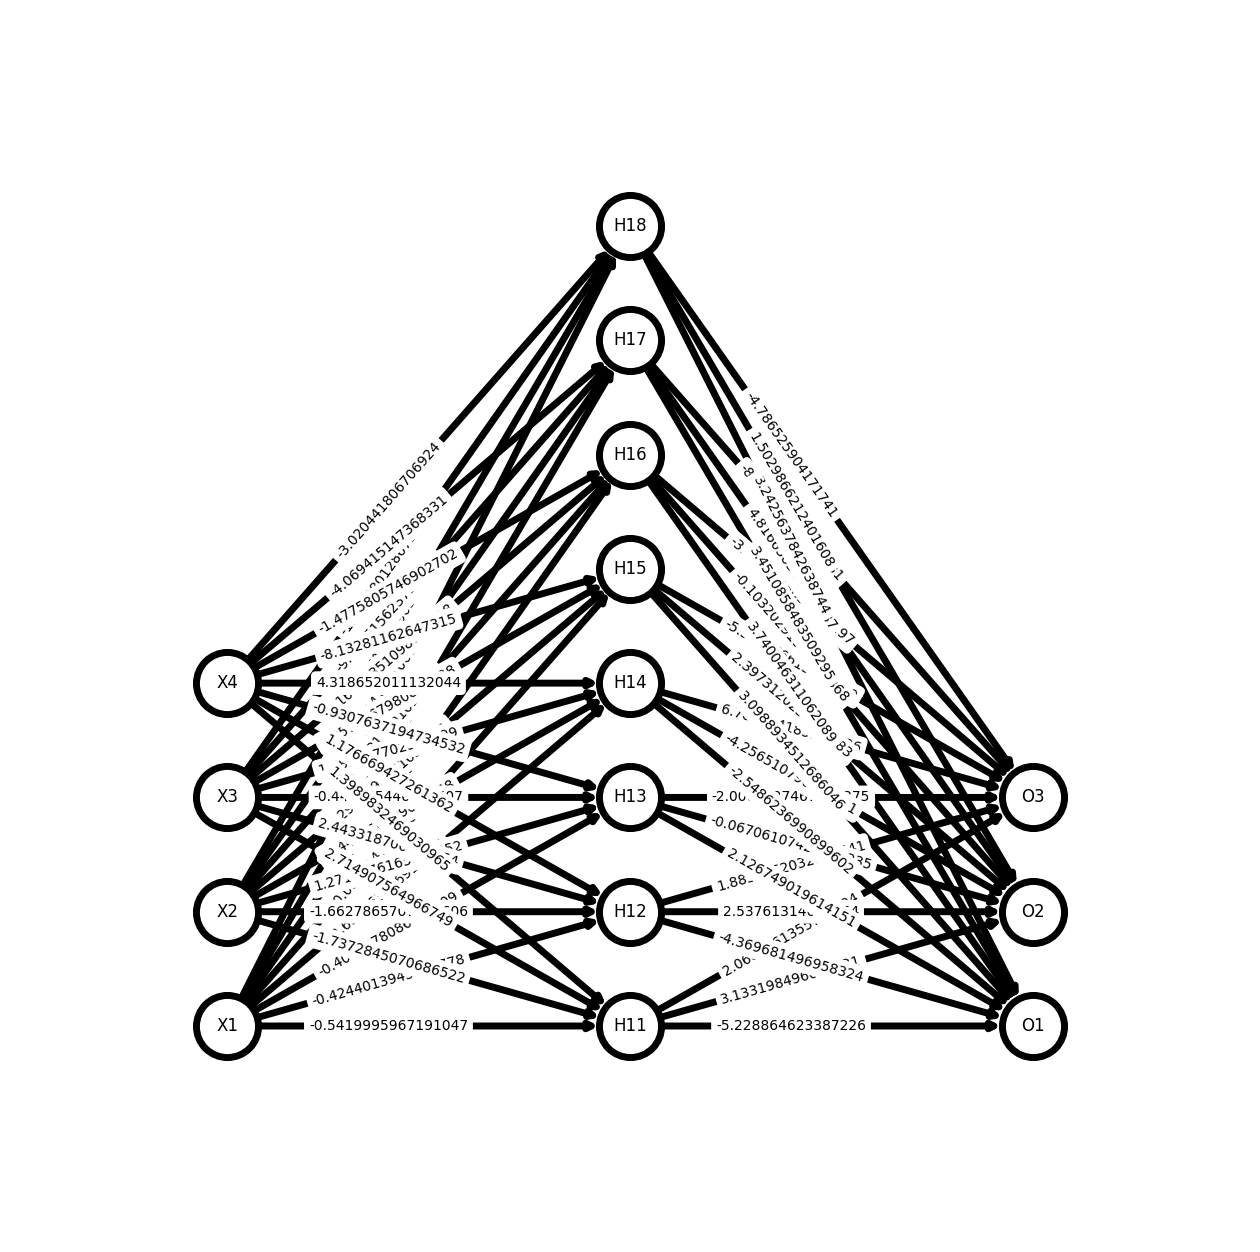

[array([[-0.3194419064406927, -0.3137054925751286, 1.1415888821574232,
         -4.518535508518437, 6.779255368536932, 1.9451467107156108,
         6.338931166210951, 5.59358801025984],
        [-0.5419995967191047, -0.4244013945999778, -0.4007678086464809,
         2.636463726913097, -0.05101474817016577, -1.135461563304386,
         7.947596641272253, 0.5029229479176455],
        [-1.7372845070686522, -1.6627865707628606, 1.2719776165880052,
         -8.441056999066948, 1.2943796241638175, 2.4214817291617217,
         -2.4781411210682944, 1.269410559963804],
        [2.714907564966749, 2.443318706889954, -0.447155446671607,
         1.681087702539399, 0.9577867980880128, -0.16333351098704618,
         -9.094515623793873, -1.9320801286758833],
        [1.3989832469030965, 1.176669427261362, -0.9307637194734532,
         4.318652011132044, -8.13281162647315, -1.4775805746902702,
         -4.069415147368331, -3.020441806706924]], dtype=object)
 array([[0.7968828449335633, -1.27332755290

In [429]:
graph = ANNGraph("to_train/iris.json")
print("Before training:")
graph.draw_ann_graph((16, 16))
graph.solve()
print("After training:")
graph.draw_ann_graph((16, 16))
graph.show_weights()